### 패키지 불러오기

In [1]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# early stopping
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

데이터셋 경로 지정

In [2]:
# 데이터셋 경로 지정
train_horse_dir = './dataset/horse-or-human/train/horses'
train_human_dir = './dataset/horse-or-human/train/humans'

학습 데이터 리스트업

In [3]:
# 학습 데이터 리스트업
train_horse_names = os.listdir(train_horse_dir)
train_human_names = os.listdir(train_human_dir)

horse_files = [train_horse_dir + '/' + f for f in train_horse_names]
human_files = [train_human_dir + '/' + f for f in train_human_names]

# 학습 데이터의 개수 확인
print('horse:', len(train_horse_names))
print('human:', len(train_human_names))

horse: 1500
human: 1581


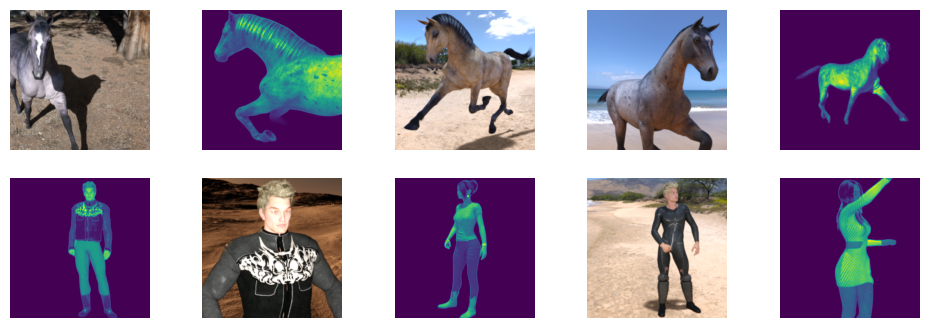

In [4]:
# 데이터 미리보기
fig, axes = plt.subplots(2,5, figsize=(12,4))
ax = np.reshape(axes, -1)

for i, path in enumerate(horse_files[:5] + human_files[:5]):
    img = plt.imread(path)
    ax[i].axis('off')
    ax[i].imshow(img)

plt.show()

### 딥러닝 모델 설계하기

In [5]:
# 모델 설계
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # 과적합 방지를 위한 Dropout 추가
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-09-05 19:14:07.891919: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-09-05 19:14:07.891964: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-09-05 19:14:07.891982: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-09-05 19:14:07.892697: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-05 19:14:07.892776: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 298, 298, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 147, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,704,097 (6.50 MB)

 Trainable params: 1,704,097 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.compile(loss='binary_crossentropy',
            optimizer=Adam(learning_rate=0.001),
            metrics=['accuracy'])

In [7]:
# 이미지 값을 0~1 사이로 제한
train_datagen = ImageDataGenerator(rescale=1/255.)

# train set
train_generator = train_datagen.flow_from_directory(
  './dataset/horse-or-human/train/',
  target_size=(300, 300),  # 해상도 조절
  batch_size=128,  # 배치 크기
  class_mode='binary'  # 분류 방법
)

# valid set
valid_generator = train_datagen.flow_from_directory(
  './dataset/horse-or-human/validation/',
  target_size=(300, 300),
  batch_size=128,
  class_mode='binary'
)

# EarlyStopping 설정
es = EarlyStopping(
    monitor='val_loss',   # val_loss를 모니터링
    patience=3,           # 개선되지 않은 3번의 epoch 이후 종료
    verbose=1,            # 콘솔에 조기 종료 로그 표시
    restore_best_weights=True  # 가장 성능이 좋은 모델 가중치로 복원
)


checkpoint = ModelCheckpoint(
  filepath='./checkpoint.keras', # 모델의 임시저장 파일을 어디에 만들것인가
  verbose=2, # 로그를 보여줄지
  save_best_only=True, # 가장 best 값만 저장할 것인가
  monitor='val_loss',
  mode='auto'
)

# 클래스 비율에 따라 가중치 계산
class_weights = {0: 3162 / (3000 + 3162),  # Horse에 대한 가중치
                 1: 3000 / (3000 + 3162)}  # Human에 대한 가중치

# steps_per_epoch 설정
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

# 모델 학습 시 class_weight 매개변수에 전달
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,  # 올바른 steps_per_epoch 값 설정
    validation_data=valid_generator,
    validation_steps=validation_steps,  # 검증 세트에 대해서도 동일하게 설정
    epochs=15,
    verbose=1,
    callbacks=[checkpoint, es],
    class_weight=class_weights  # 클래스 가중치 적용
)

Found 3081 images belonging to 2 classes.
Found 768 images belonging to 2 classes.
Epoch 1/15


2024-09-05 19:14:10.682661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7303 - loss: 0.2778
Epoch 1: val_loss improved from inf to 0.38939, saving model to ./checkpoint.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.7339 - loss: 0.2751 - val_accuracy: 0.8750 - val_loss: 0.3894
Epoch 2/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9219 - loss: 0.1027
Epoch 3/15


2024-09-05 19:14:59.033728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_10/_46]]
2024-09-05 19:14:59.033775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-05 19:14:59.033818: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5588535692726966334
2024-09-05 19:14:59.033827: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1132476225536394741
2024-09-05 19:14:59.033835: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15020574521528444651
2024-09-05 19:14:59.033841: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 276490816

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9127 - loss: 0.1114
Epoch 3: val_loss improved from 0.38939 to 0.33604, saving model to ./checkpoint.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9125 - loss: 0.1114 - val_accuracy: 0.8984 - val_loss: 0.3360
Epoch 4/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9453 - loss: 0.0850
Epoch 5/15


2024-09-05 19:15:41.832872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1/stateless_dropout/stateless_random_uniform/StatelessRandomGetKeyCounter/_84]]
2024-09-05 19:15:41.832942: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2764908169220710894
2024-09-05 19:15:41.832966: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12361166347881400046
2024-09-05 19:15:41.832981: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2321772726676604944
2024-09-05 19:15:41.832993: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4050592911778490688
2024-09-05 19:15:41.833012: I tensorflow/core/framework/local_rendezvous.cc:422] Local ren

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9287 - loss: 0.0865
Epoch 5: val_loss did not improve from 0.33604
24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9290 - loss: 0.0863 - val_accuracy: 0.8802 - val_loss: 0.4540
Epoch 6/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9688 - loss: 0.0613
Epoch 7/15


2024-09-05 19:16:27.751361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-05 19:16:27.751735: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5588535692726966334
2024-09-05 19:16:27.751766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_28/_44]]
2024-09-05 19:16:27.751806: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2764908169220710894
2024-09-05 19:16:27.751826: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11410744280886344448
2024-09-05 19:16:27.751835: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 113247622

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9505 - loss: 0.0688
Epoch 7: val_loss did not improve from 0.33604
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.9508 - loss: 0.0685 - val_accuracy: 0.8737 - val_loss: 0.5927
Epoch 8/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9688 - loss: 0.0329
Epoch 9/15


2024-09-05 19:17:19.859471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_12/_48]]
2024-09-05 19:17:19.859522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-05 19:17:19.859541: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18349140638945406408
2024-09-05 19:17:19.859555: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1132476225536394741
2024-09-05 19:17:19.859572: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2764908169220710894
2024-09-05 19:17:19.859582: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 150205745

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9744 - loss: 0.0346
Epoch 9: val_loss did not improve from 0.33604
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9745 - loss: 0.0345 - val_accuracy: 0.8802 - val_loss: 0.6557
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 3.


모델 평가

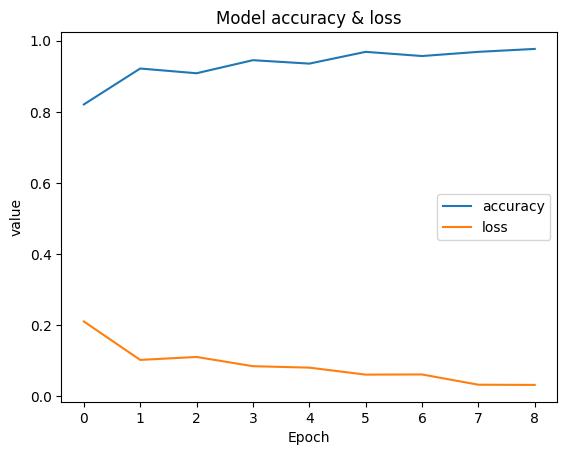

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model accuracy & loss')
plt.xlabel('Epoch')
plt.ylabel('value')
plt.legend(['accuracy', 'loss'], loc='center right')
plt.show()

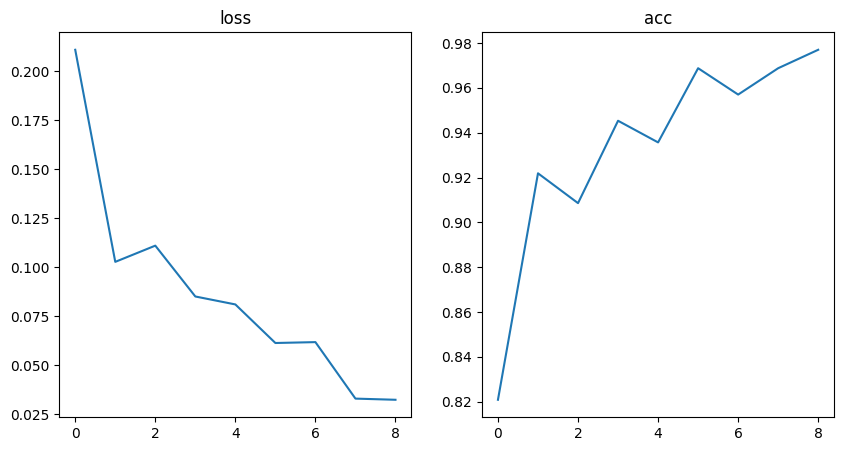

In [9]:
#loss, acc 현황을 그래프로 확인
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title("loss")
plt.subplot(1, 2, 2)
plt.title("acc")
plt.plot(history.history['accuracy'])
plt.show()

모델 검증

In [10]:
# 모델 검증
results = model.evaluate(valid_generator)
print("test loss, test acc:", results)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 446ms/step - accuracy: 0.8946 - loss: 0.3439
test loss, test acc: [0.3360380232334137, 0.8984375]


외부 데이터 테스트

In [11]:
# 이미지 전처리
dlist = './dataset/horse-or-human/test/'
predict_list = os.listdir(dlist)
print(predict_list)

img = [cv2.imread(dlist + i) for i in predict_list]
img = [cv2.resize(i, (300,300)) for i in img]
img = np.array(img)
img = img.astype('float32') / 255.0

# 분류
cutoff = .5
predictions = model.predict(img)
print(predictions >= cutoff)

['horse2.webp', 'human1.jpg', 'human2.jpg', 'horse3.jpg', 'horse1.jpg']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
[[False]
 [False]
 [ True]
 [ True]
 [False]]


In [12]:
model.save('./model.keras')

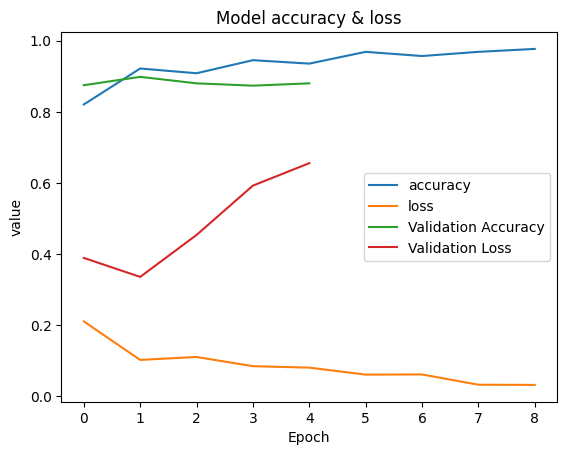

In [13]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"])
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["val_loss"])

plt.title("Model accuracy & loss")
plt.xlabel("Epoch")
plt.ylabel("value")
plt.legend(
    ["accuracy", "loss", "Validation Accuracy", "Validation Loss"], loc="center right"
)
plt.show()